# Banknote Dataset
O conjunto de dados de notas envolve prever se uma determinada nota é autêntica, dadas várias medidas tomadas em uma fotografia.




# Importando as bibliotecas

In [1]:
# data analysis
import numpy as np
import pandas as pd 

# data visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import matplotlib.colors
from matplotlib import rcParams
labelsize = 14
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 
import seaborn as sns
sns.set_style('white')

# machine learning...
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import recall_score, roc_auc_score, roc_curve

# Funções
Vamos otimizar nosso processo criando algumas funções que vamos usar com mais frequência 

## Avaliação dos modelos


In [2]:
def eval_models(X, y, model, metric='accuracy'):
    """
    Função para avaliar os modelos
    --------------------------------------------------------------
    Parametros:
    X = valores de entrada (input values)
    y = variável alvo (target value)
    model = modelo que sera avaliado
    metric = metrica de desempenho. Por padrão "accuracy". Obs: para classes desbalanceadas não é melhor metrica de avaliação.
    consultar link para ver outras opções : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    --------------------------------------------------------------
    Retorna:
    Pontuação (score) do modelo avaliado
    
    """
    # definindo nosso KFold Cross-Validation.
    kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # avaliando com cross_val_score
    scores = cross_val_score(model, X, y, scoring=metric, cv=kf, n_jobs=-1)
    # retornando pontuação
    return scores

## Definição dos modelos

In [3]:
def get_models(models=dict()):
    """
    Retorna um dicionário de nomes de modelos mapeados para o objeto de modelo scikit-learn
    """
    # MODELOS LINEARES
    models['log'] = LogisticRegression()
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alphas:
        models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
    models['pac'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
    models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
    models['lda'] = LinearDiscriminantAnalysis()
    
    # MODELOS NAO LINEARES
    for k in range(1, 21):
        models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
    models['cart'] = DecisionTreeClassifier()
    models['extra'] = ExtraTreeClassifier()
    models['svml'] = SVC(kernel='linear')
    models['svmp'] = SVC(kernel='poly')
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr-'+str(c)] = SVC(C=c)
    models['nb'] = GaussianNB()
    
    # MODELOS ENSEMBLE
    models['ada'] = AdaBoostClassifier(n_estimators=100)
    models['rf'] = RandomForestClassifier(n_estimators=100)
    models['gb'] = GradientBoostingClassifier(n_estimators=100)
    models['xgb'] = XGBClassifier()
    models['lgb'] = LGBMClassifier(n_estimators=100)
    
    print(f"Foram definidos {len(models)} modelos:")
    return models

## Apresentação dos resultados

In [4]:
def show_results(resultados, maximize=True, top_n=10):
    """
     Seleciona os melhores modelos e os apresenta em forma de ranking do melhor para o pior.
    resultados = dict contendo nome do modelo atrelado ao seu score
    maximize = por padrao True.
    top_n = Indica quantos modelo apresentar. Por padrão 10
    """
    meanScores = [(k, v.mean()) for k, v in resultados.items()] # gerando a tupla com (nome, media(pontuação))
    meanScores = sorted(meanScores, key=lambda x: x[1]) # ordenando do menor para o maior
    if maximize:
        meanScores = list(reversed(meanScores)) # faz a reversão do resultado (maior pra menor)
    nomes = [x[0] for x in meanScores[:top_n]] # pegando os nomes dos melhores resultados
    scores = [resultados[x[0]] for x in meanScores[:top_n]] # armazenando as pontuaçães
    # criando o loop para apresentar os resultados
    for i in range(top_n):
        nome = nomes[i]
        meanScore, stdScore = resultados[nome].mean(), resultados[nome].std()
        print(f"Pos:{i+1}, Model:{nome}, Score:{round(meanScore, 4)} ({round(stdScore, 4)})")
        
    # plotar o resultados
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(scores, showmeans=True)
    ax.set_title("Best Models Result", fontsize=17)
    ax.set_xticklabels(labels=nomes, rotation=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    

# Importando dados

In [5]:
names = ['variance', 'skewness','kurtosis','entropy','class']

# instanciando o DataFrame
bankDf = pd.read_csv('https://raw.githubusercontent.com/DanOliveira-DS/Datasets_for_Practicing_Applied_Machine_Learning/master/csv%20files/banknote_authentication.csv', header=None, names=names)


Os dados foram extraídos de imagens referentes a notas de banco originais e falsas. Essas imagens então foram digitalizadas e analisadas utilizando a transformada continua de wavelet (CWT) para extrair os recursos (features) que compõem nosso conjunto de dados. Caso queira saber mais sobre essa transformada vou deixar um link de um artigo hospedado na [scielo](https://www.scielo.br/pdf/rbef/v38n3/1806-1117-rbef-38-03-e3314.pdf) 



In [6]:
# verificando as primeiras entradas
print(bankDf.head())

   variance  skewness  kurtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0


Os nomes das nossas features são os seguintes:

* Variação da imagem (CWT).
* Inclinação da imagem (CWT).
* Kurtosis da imagem (CWT).
* Entropia da imagem.
* Classe (0 para autêntico, 1 para inautêntico).

# EDA


## Começando pelo Básico

### Qual o tamanho do conjunto de dados?
A primeira coisa que faremos após importar o dataset será examinar as dimensões do DataFrame e as primeiras entradas. Isso possibilitará criar uma consciência situacional inicial a respeito do formato de entrada e da estrutura geral dos dados.

Em relação à dimensionalidade dos dados, nosso conjunto de dados é composto por 1372 observações(entradas) sendo 4 variáveis de entrada e 1 variável de saída (variável alvo).

In [7]:
# size of dataset
print(f"dimensões do conjunto de dados".upper())
print(f"Observações: {bankDf.shape[0]}")
print(f"Features: {bankDf.shape[1]}")

DIMENSÕES DO CONJUNTO DE DADOS
Observações: 1372
Features: 5


### Quais são os tipos de dados das minhas features?
Vamos realizar o levantamento dos tipos de variáveis que compõem o DataFrame a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas. 

In [8]:
# types of my features
print(bankDf.dtypes)

variance    float64
skewness    float64
kurtosis    float64
entropy     float64
class         int64
dtype: object


Nosso conjunto de dados apresenta apenas variáveis numéricas. Um ponto positivo já que os algoritmos de machine learning gostam de trabalhar com dados numéricos. Nosso caso de variáveis categóricas precisamos primeiro tratá-las antes de alimentar nosso modelo. 

###  Valores Ausentes
Um passo importante na análise de dados é verificação de dados ausentes, isso porque a qualidade de um conjunto de dados está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas. Caso eles sejam significativos será necessário um tratamento nos dados antes de realizarmos nossas análises 

In [9]:
# Null Values
print("Quantidade de valores ausentes por feature:")
print(bankDf.isnull().sum())

Quantidade de valores ausentes por feature:
variance    0
skewness    0
kurtosis    0
entropy     0
class       0
dtype: int64


Como podemos ver temos um conjunto de dados bem limpo que não apresenta valores ausentes.

### Resumo estatístico
O método `pd.describe()` nos ajuda a visualizar as propriedades estatísticas de variáveis numéricas. Exclui variáveis de caracteres.

Imediatamente você obtém um resumo contendo algumas das principais informações estatísticas relevantes:

* **count** - quantidade de entradas válidas
* **mean** - média dos valores
* **std** - desvio padrão
* **min** - menor valor da coluna
* **25%** - (Q1) primeiro quartil 25
* **50%** - mediana
* **75%** - (Q3) terceiro quartil 75
* **max** - maior valor da coluna

Com método `pd.describe()` é possível identificar colunas com possíveis outliers (por exemplo, olhando o valor da mediana e comparando com valores máximos e mínimos)

In [10]:
# describe data
print(bankDf.describe())

          variance     skewness     kurtosis      entropy        class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000


Conclusões:
* A primeira vista pode parecer que nossas features apresentam *outliers* pelo que foi dito acima. Entretanto vale lembra que nossos dados passaram por uma transformação que foi a `transformada contínua de Wavelet (*CWT*)`. Isso fica evidente quando olhamos para nosso resumo estatístico que apresenta o comportamento da transformada utilizada. Isso não garante que nosso conjunto de dados não possua *outiliers*. Uma maneira de fazer essa verificação é utilizando box plots


## Visualização dos Dados


### Plotar as distribuiçoes numéricas

#### Histograma
Uma maneira rápida de ter uma ideia da distribuição de cada atributo é observar os histogramas. Os histogramas agrupam dados em posições e fornecem uma contagem do número de observações em cada posição. A partir da forma das caixas, você pode ter uma ideia rápida de se um atributo é gaussiano, inclinado(`skewed`) ou mesmo tem uma distribuição exponencial. Também pode ajudar a ver possíveis discrepâncias. 

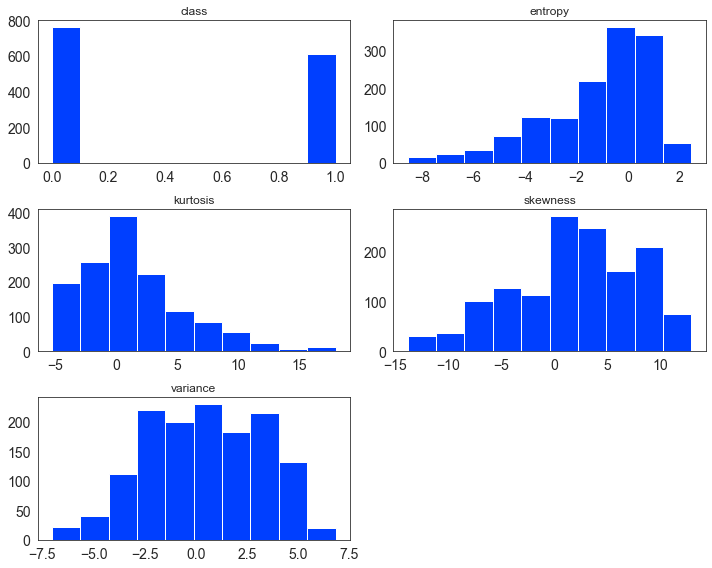

In [11]:
# hist
bankDf.hist(figsize=(10,8), grid=False)
plt.tight_layout()

#### Boxplot  
Um gráfico de caixa é um método para representar graficamente grupos de dados numéricos através de seus quartis. A caixa se estende dos valores do quartil Q1 a Q3 dos dados, com uma linha na mediana (Q2). Os bigodes se estendem desde as bordas da caixa para mostrar o intervalo dos dados. A posição dos bigodes é definido por padrão como `[1.5 * IQR (IQR = Q3 – Q1)]` nas bordas da caixa. Pontos extremos são aqueles que passaram do fim dos bigodes.


<p align="center">
  <img width=700 src="https://miro.medium.com/max/1218/1*r41SQj0LbdCV6rWoIos6mA.png">
</p>   

Vamos à visualização:

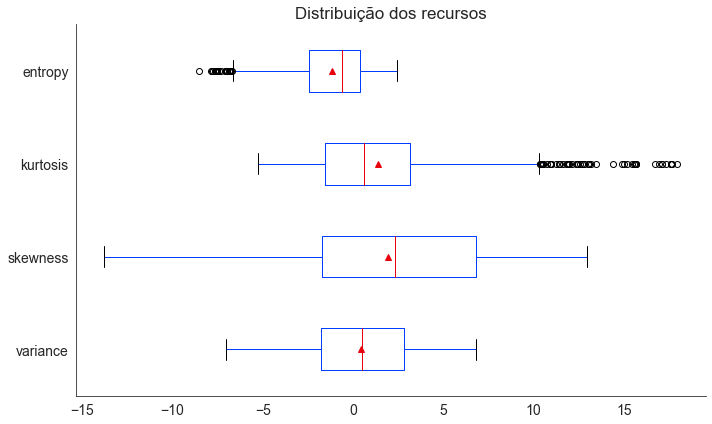

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
bankDf.boxplot(column=['variance','skewness','kurtosis','entropy'], showmeans=True, vert=False, ax=ax, grid=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Distribuição dos recursos', fontsize=17)

plt.tight_layout()

Agora vamos as distribuições para cada classe.

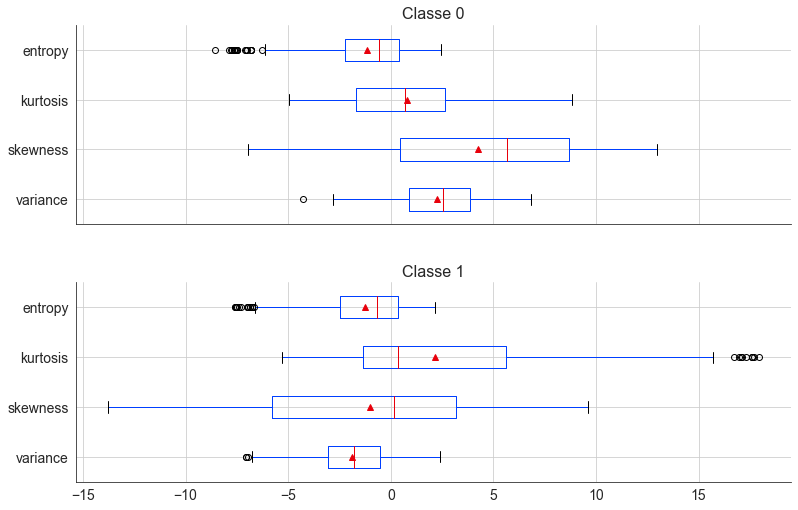

In [13]:
# criando DataFrame com os dados autenticos class=0
bankAut = bankDf[bankDf['class']==0]
# criando DataFrame com os dados falsos class=1
bankFal = bankDf[bankDf['class']==1]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True, )
bankAut.boxplot(column=['variance','skewness','kurtosis','entropy'], vert=False, figsize=(8, 4), showmeans=True, ax=ax1)
ax1.set_title('Classe 0', fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
bankFal.boxplot(column=['variance','skewness','kurtosis','entropy'], vert=False, figsize=(8, 4), showmeans=True, ax=ax2)
ax2.set_title("Classe 1", fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout(pad=4.0)

Tivemos um resultado bastante interessante. 
* `Classe 1` que representa nossos dados falsos apresentam mais *outliers* que a `classe 0` principalmente a feature `kurtosis`
* Dados negativos para as features `[skewness,variance]` podem ser um indicativo de que as notas bancarias possam ser falsas

### Análise da variálvel alvo
Nosso objetivo é verificar como está o balanceamento da nossa variável alvo no conjunto de dados. Isso porque dados desequilibrados é algo comum e a maioria dos conjuntos de dados de classificação não possui um número exatamente igual de instâncias em cada classe, mas uma pequena diferença geralmente não importa. Já em problemas onde temos classes altamente desequilibradas algumas estratégias podem ser adotadas, como:
* **Coletar mais dados**(Caso possível): Um conjunto de dados maior pode expor uma perspectiva diferente e talvez mais equilibra sobre as classes


* **Mudar a métrica de avaliação**: Acurácia(*Accuracy*) não é a métrica a ser usada ao trabalhar com um conjunto de dados desequilibrados. Existem métricas que foram projetadas para contar uma história mais verdadeira ao trabalhar com classes desequilibradas:
    
    >* Matriz de Confusão;
    >* Precisão;
    >* Recall;
    >* pontuação f1;
    >* Kappa de cohen;
    >* Curva ROC.    
* **Alterar o conjunto de dados**: Utilizar métodos como *Oversampling* e *Undersampling*

Distribuição da variável alvo:
0    762
1    610
Name: class, dtype: int64


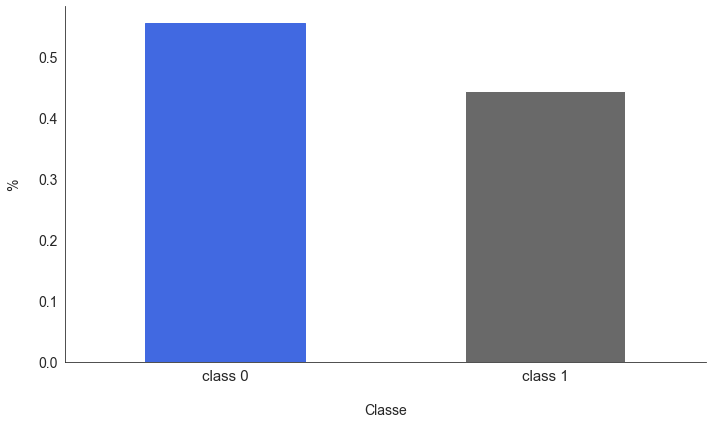

In [14]:
# mostrando distribuica da variavel alvo
print('Distribuição da variável alvo:')
print(f"{bankDf['class'].value_counts()}")

# Target variable
labels=['class 0', 'class 1']
fig, ax = plt.subplots(figsize=(10,6))
bankDf['class'].value_counts(normalize=True).plot(kind='bar', color='dimgrey', ax=ax)
ax.set_xlabel("Classe", fontsize=14, labelpad=20)
ax.set_ylabel("%", fontsize=14, labelpad=17)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(labels=labels, fontsize=15, rotation=0)
ax.patches[0].set_color('royalblue')
plt.tight_layout()

Nosso conjunto de dados não apresenta um desbalanceamento tão significativo. Uma simples mudança na métrica de avaliação deve gerar bons resultados.

Um gráfico de dispersão mostra o relacionamento entre duas variáveis como pontos em duas dimensões, um eixo para cada atributo. São úteis para identificar relacionamentos estruturados entre variáveis. Os atributos com relacionamentos estruturados também podem ser correlacionados e bons candidatos para remoção do seu conjunto de dados. Como o gráfico da matriz de correlação, a matriz do gráfico de dispersão é simétrica. Isso é útil para analisar os relacionamentos entre pares de diferentes perspectivas. Como há pouco sentido em desenhar um gráfico de dispersão de cada variável consigo, a diagonal mostra histogramas de cada atributo.

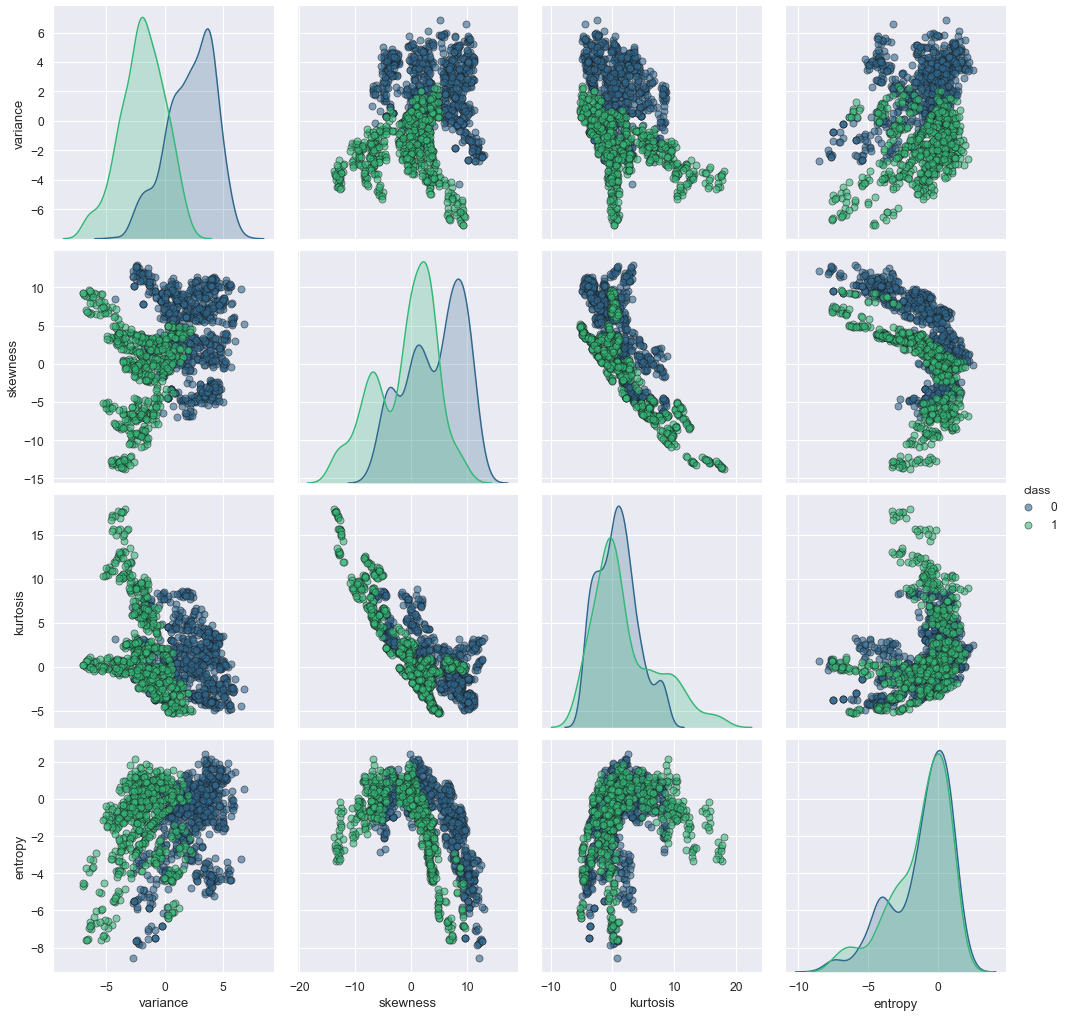

In [106]:
sns.set(font_scale=1.1)
sns.pairplot(bankDf, hue='class', height=3.5,
             diag_kind='kde', palette='viridis',
             plot_kws = {'alpha': 0.6, 's': 50, 'edgecolor': 'k'}
            );

# Dividir os dados Treino/Teste

In [15]:
# train/test split
X = bankDf.loc[:,:'entropy']
y = bankDf['class']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=1)

# Modelo de Referência(*Baseline*)
O DummyClassifier nos permite criar um modelo muito simples que podemos usar como referência para comparar com outros modelos


In [16]:
# criar modelo de referencia
naive = DummyClassifier(strategy='most_frequent')
scores = eval_models(X_train, y_train, model=naive)

In [17]:
print(f"{scores}")
print(f"\nBaseline Accuracy: {round(scores.mean()*100, 4)}% ({round(scores.std(), 4)})")

[0.55434783 0.55434783 0.55434783 0.54347826 0.54347826 0.54347826
 0.54347826 0.54347826 0.54347826 0.54945055 0.55434783 0.55434783
 0.55434783 0.54347826 0.54347826 0.54347826 0.54347826 0.54347826
 0.54347826 0.54945055 0.55434783 0.55434783 0.55434783 0.54347826
 0.54347826 0.54347826 0.54347826 0.54347826 0.54347826 0.54945055]

Baseline Accuracy: 54.7336% (0.0049)


Nosso modelo de referência atingiu uma acurácia de ~54%. Vamos agora avaliar os modelos definidos e ver se conseguimos resultados melhores.

# Avaliar Modelos

In [18]:
# instanciando modelos
models = get_models()
# dicionario que vai conter o resulta atrelado ao nome do modelo avaliado
resultados = dict()

# iterar pelo nome e modelo do nosso dicionario de modelos
for name, model in models.items():
    scores = eval_models(X_train, y_train, model, metric='recall') # avaliando os modelos utilizando nossa função de avaliação
    resultados[name] = scores # armezando o nome e a pontuação
    print(f"Model:{name}, Score:{round(scores.mean()*100, 4)} ({round(scores.std(), 4)})")

Foram definidos 54 modelos:
Model:log, Score:99.518 (0.0096)
Model:ridge-0.1, Score:99.758 (0.0073)
Model:ridge-0.2, Score:99.758 (0.0073)
Model:ridge-0.3, Score:99.758 (0.0073)
Model:ridge-0.4, Score:99.758 (0.0073)
Model:ridge-0.5, Score:99.758 (0.0073)
Model:ridge-0.6, Score:99.758 (0.0073)
Model:ridge-0.7, Score:99.758 (0.0073)
Model:ridge-0.8, Score:99.758 (0.0073)
Model:ridge-0.9, Score:99.758 (0.0073)
Model:ridge-1.0, Score:99.758 (0.0073)
Model:pac, Score:97.2745 (0.0283)
Model:sgd, Score:98.2482 (0.0238)
Model:lda, Score:99.758 (0.0073)
Model:knn-1, Score:100.0 (0.0)
Model:knn-2, Score:100.0 (0.0)
Model:knn-3, Score:100.0 (0.0)
Model:knn-4, Score:100.0 (0.0)
Model:knn-5, Score:100.0 (0.0)
Model:knn-6, Score:99.9206 (0.0043)
Model:knn-7, Score:99.9206 (0.0043)
Model:knn-8, Score:99.7619 (0.0071)
Model:knn-9, Score:100.0 (0.0)
Model:knn-10, Score:100.0 (0.0)
Model:knn-11, Score:100.0 (0.0)
Model:knn-12, Score:100.0 (0.0)
Model:knn-13, Score:100.0 (0.0)
Model:knn-14, Score:100.0 

Pos:1, Model:svmr-1.0, Score:1.0 (0.0)
Pos:2, Model:svmr-0.9, Score:1.0 (0.0)
Pos:3, Model:svmr-0.8, Score:1.0 (0.0)
Pos:4, Model:svmr-0.7, Score:1.0 (0.0)
Pos:5, Model:svmr-0.6, Score:1.0 (0.0)
Pos:6, Model:svmr-0.5, Score:1.0 (0.0)
Pos:7, Model:svmr-0.4, Score:1.0 (0.0)
Pos:8, Model:svmr-0.3, Score:1.0 (0.0)
Pos:9, Model:svmr-0.2, Score:1.0 (0.0)
Pos:10, Model:svmr-0.1, Score:1.0 (0.0)


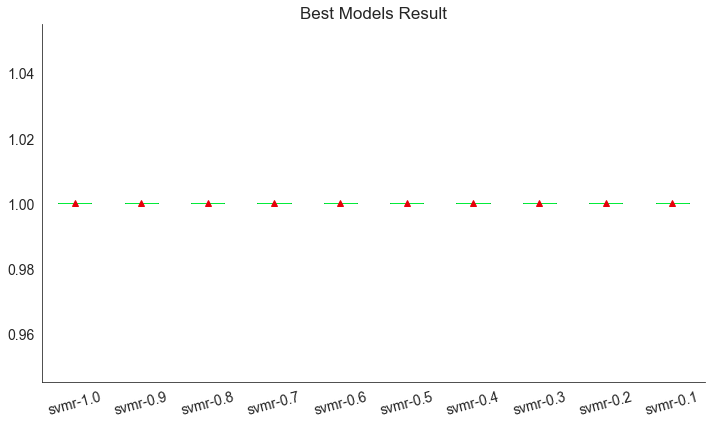

In [19]:
# apresentar os resultados
show_results(resultados)

# Transformadores
Como sabemos nossos dados passaram por uma transformação que foi a transformada contínua de Wavelet. Em geral alguns algoritmos de aprendizado de máquina têm um desempenho muito melhor se todas as variáveis forem dimensionadas para o mesmo intervalo, como dimensionar todas as variáveis para valores entre 0 e 1, denominado normalização(*MinMaxScaler*). Isso afeta algoritmos que usam uma soma ponderada da entrada, como modelos lineares e redes neurais, bem como modelos que usam medidas de distância, como máquinas de vetores de suporte(*SVM*) e vizinhos k-mais próximos(*KNN*).

Vamos criar algumas funções que aplicarão transformadores em nossos dados e ver como ele afeta o resultado.

In [20]:
def pipeNone(model):
    return model

def pipeNorm(model):
    steps = []
    steps.append(('n', MinMaxScaler()))
    steps.append(('m', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

def pipeStd(model):
    steps = []
    steps.append(('s', StandardScaler()))
    steps.append(('m', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

def pipeRobu(model):
    steps = []
    steps.append(('r', RobustScaler()))
    steps.append(('m', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

def pipeQuant(model):
    steps = []
    steps.append(('q', QuantileTransformer()))
    steps.append(('m', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

pipelines = [pipeNone, pipeNorm, pipeStd, pipeRobu, pipeQuant]

In [21]:
models = get_models()

resultados = dict()

for name, model in models.items():
    for i in range(len(pipelines)):
        scores = eval_models(X_train, y_train, model=pipelines[i](model), metric='recall')
        resultados["["+str(i)+"]"+name] = scores
        print(f"Model:[{i}]{name}, Score:{round(scores.mean(), 4)} ({round(scores.std(), 4)})")

Foram definidos 54 modelos:
Model:[0]log, Score:0.9952 (0.0096)
Model:[1]log, Score:0.9728 (0.0289)
Model:[2]log, Score:0.9968 (0.0081)
Model:[3]log, Score:1.0 (0.0)
Model:[4]log, Score:0.9952 (0.0096)
Model:[0]ridge-0.1, Score:0.9976 (0.0073)
Model:[1]ridge-0.1, Score:0.9976 (0.0073)
Model:[2]ridge-0.1, Score:0.9976 (0.0073)
Model:[3]ridge-0.1, Score:0.9976 (0.0073)
Model:[4]ridge-0.1, Score:1.0 (0.0)
Model:[0]ridge-0.2, Score:0.9976 (0.0073)
Model:[1]ridge-0.2, Score:0.9976 (0.0073)
Model:[2]ridge-0.2, Score:0.9976 (0.0073)
Model:[3]ridge-0.2, Score:0.9976 (0.0073)
Model:[4]ridge-0.2, Score:1.0 (0.0)
Model:[0]ridge-0.3, Score:0.9976 (0.0073)
Model:[1]ridge-0.3, Score:0.9984 (0.006)
Model:[2]ridge-0.3, Score:0.9976 (0.0073)
Model:[3]ridge-0.3, Score:0.9976 (0.0073)
Model:[4]ridge-0.3, Score:1.0 (0.0)
Model:[0]ridge-0.4, Score:0.9976 (0.0073)
Model:[1]ridge-0.4, Score:0.9984 (0.006)
Model:[2]ridge-0.4, Score:0.9976 (0.0073)
Model:[3]ridge-0.4, Score:0.9976 (0.0073)
Model:[4]ridge-0.4, 

Model:[2]svmr-0.9, Score:1.0 (0.0)
Model:[3]svmr-0.9, Score:1.0 (0.0)
Model:[4]svmr-0.9, Score:1.0 (0.0)
Model:[0]svmr-1.0, Score:1.0 (0.0)
Model:[1]svmr-1.0, Score:1.0 (0.0)
Model:[2]svmr-1.0, Score:1.0 (0.0)
Model:[3]svmr-1.0, Score:1.0 (0.0)
Model:[4]svmr-1.0, Score:1.0 (0.0)
Model:[0]nb, Score:0.7918 (0.0716)
Model:[1]nb, Score:0.7918 (0.0716)
Model:[2]nb, Score:0.7918 (0.0716)
Model:[3]nb, Score:0.7918 (0.0716)
Model:[4]nb, Score:0.8525 (0.0554)
Model:[0]ada, Score:0.9968 (0.0081)
Model:[1]ada, Score:0.9968 (0.0081)
Model:[2]ada, Score:0.9968 (0.0081)
Model:[3]ada, Score:0.9968 (0.0081)
Model:[4]ada, Score:0.9968 (0.0081)
Model:[0]rf, Score:0.9984 (0.0085)
Model:[1]rf, Score:0.9984 (0.0059)
Model:[2]rf, Score:0.9984 (0.006)
Model:[3]rf, Score:0.9968 (0.0102)
Model:[4]rf, Score:0.9968 (0.0102)
Model:[0]gb, Score:0.9936 (0.0122)
Model:[1]gb, Score:0.9936 (0.0122)
Model:[2]gb, Score:0.9936 (0.0122)
Model:[3]gb, Score:0.9936 (0.0122)
Model:[4]gb, Score:0.9936 (0.0122)
Model:[0]xgb, Sc

Pos:1, Model:[4]svmr-1.0, Score:1.0 (0.0)
Pos:2, Model:[3]svmr-1.0, Score:1.0 (0.0)
Pos:3, Model:[2]svmr-1.0, Score:1.0 (0.0)
Pos:4, Model:[1]svmr-1.0, Score:1.0 (0.0)
Pos:5, Model:[0]svmr-1.0, Score:1.0 (0.0)
Pos:6, Model:[4]svmr-0.9, Score:1.0 (0.0)
Pos:7, Model:[3]svmr-0.9, Score:1.0 (0.0)
Pos:8, Model:[2]svmr-0.9, Score:1.0 (0.0)
Pos:9, Model:[1]svmr-0.9, Score:1.0 (0.0)
Pos:10, Model:[0]svmr-0.9, Score:1.0 (0.0)


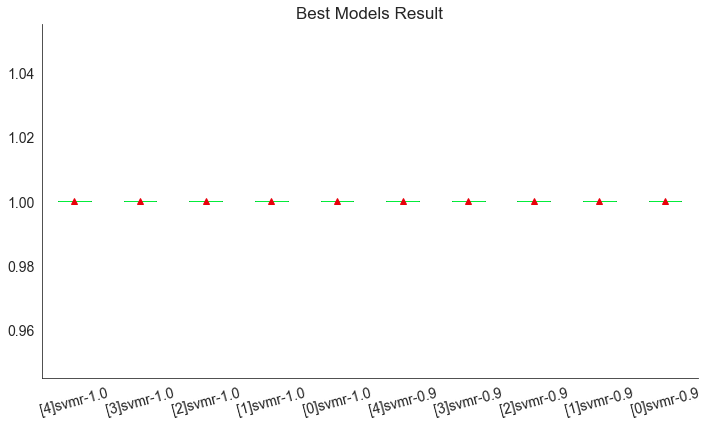

In [22]:
show_results(resultados)

# Modelo Final
Como praticamente todos nossos modelos tiverem um bom desempenho. Vou usar o algoritmo de Regressão Logística para ser nosso modelo final. Isso por diferente dos outros algoritmos que definimos a regressão logística não possui realmente nenhum parâmetro crítico para ajustar. Às vezes, você pode ver diferenças úteis no desempenho ou na convergência com diferentes solucionadores (*solver*). Para esse problema em questão não vamos realizar nenhum ajuste de paramêtro.

In [23]:
# modelos mais simples Regressão Logística
model = LogisticRegression()
transformer = RobustScaler()

# pipeline
pipeline = Pipeline(steps=[('t', transformer), ('m', model)])

In [42]:
scores = eval_models(X_train, y_train, model=pipeline, metric='f1')

In [43]:
scores

array([0.96470588, 1.        , 0.97619048, 0.98823529, 0.98823529,
       0.97674419, 0.97674419, 0.97674419, 0.97674419, 0.98795181,
       0.96470588, 0.98795181, 0.97619048, 0.97674419, 0.97674419,
       0.98823529, 0.96551724, 0.97674419, 1.        , 1.        ,
       0.95348837, 1.        , 1.        , 0.96551724, 0.98823529,
       0.96551724, 0.96551724, 1.        , 1.        , 0.97619048])

In [44]:
scores.mean()

0.9813198208047192

In [45]:
# treinando modelo final
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('t',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('m',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [46]:
# realizando as previsões
p = pipeline.predict(X_valid)

## Avaliando modelo final
Para avaliar nosso modelo vamos utilizar as seguintes métricas:
* **Relatório de Classificação** (*Classification Report*) - Exibe a precisão (*precision*), recuperação (*recall*), pontuação F1 (*f1 score*) e suporte (*support*)

     * **Precisão** : É a capacidade do classificador não rotular uma observação negativa verdadeira como positiva.  Mede a **exatidão** dos classificadores
     * **Recuperação**: É a capacidade do classificador de encontrar exemplos positivos. Se quiséssemmos ter certeza de encontrar todos os exemplos positivos poderiamos maximizar o recall. Mede a **integridade** dos classificadores
     * **Pontuação f1**: É a média harmônica de precisão e recall. Os valores variam de 0(ruim) a 1(bom).
     * **Suporte**: É o numero de ocorrências de cada classe.
     
* **Cohen Kappa**: precisão da classificação normalizada pelo desequilibrio das classes nos dados



* **ROC AUC Score**: Capacidade de um modelo de discriminar entre classes positivas e negativas. Uma área de `1` representa um modelo que fez todas as previsões perfeitamente. Uma área de `0.5` representa um modelo tão bom quanto aleatório

In [47]:
# metricas
# classification report
print(f"Relatório de Classificação:\n\n{classification_report(y_valid,p)}")
print("-"*60)
print(f"Cohen Kappa Score: {round(cohen_kappa_score(y_valid, p), 4)}")
print("-"*60)
print(f"ROC AUC Score: {round(roc_auc_score(y_valid, p), 4)}")

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       259
           1       0.96      0.99      0.98       194

    accuracy                           0.98       453
   macro avg       0.98      0.98      0.98       453
weighted avg       0.98      0.98      0.98       453

------------------------------------------------------------
Cohen Kappa Score: 0.9596
------------------------------------------------------------
ROC AUC Score: 0.9813


Nosso modelo se saiu muito bem

## Gráficos
Vamos apresentar de forma gráfica como nosso modelo avaliou nosso problema usando 
* **Matrix de confusão**: é uma apresentação útil da precisão de um modelo com duas ou mais classes. A tabela apresenta previsões no eixo *x* e os resultados de precisão no eixo *y*. 

* **Curva ROC**:  é um gráfico da taxa positiva verdadeira e da taxa positiva falsa para um determina conjunto de previsões de probabilidades em diferentes limites usados para mapear as probabilidades para os rótulos das classes. A área sob a curva é então a integral aproximada sob a curva ROC. É a representação gráfica do resultado apresentado anteriormente (*`ROC AUC Score: 0.9813`*)


### Matrix de confusão

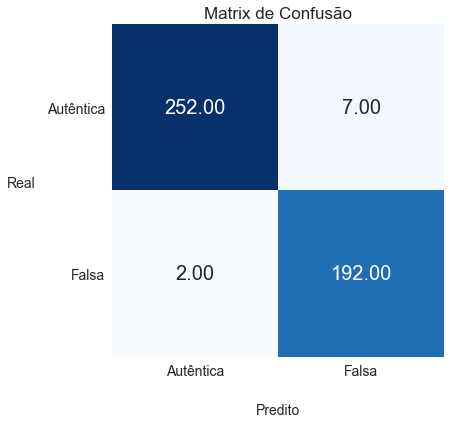

In [48]:
matrix = confusion_matrix(y_valid, p) # criando matrix de confusão
confusionDf = pd.DataFrame(matrix, index=[0, 1], columns=['Autêntica','Falsa'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusionDf, cmap='Blues', cbar=None, square=True, annot=True, fmt='.2f', linecolor='white', annot_kws={"size": 20}, ax=ax)
ax.set_title("Matrix de Confusão", fontsize=17)
ax.set_ylabel("Real", fontsize=14, rotation=0, labelpad=25)
ax.set_yticklabels(labels=['Autêntica','Falsa'], rotation=0)
ax.set_xlabel("Predito", fontsize=14, rotation=0, labelpad=25)

plt.tight_layout()

### Curva ROC

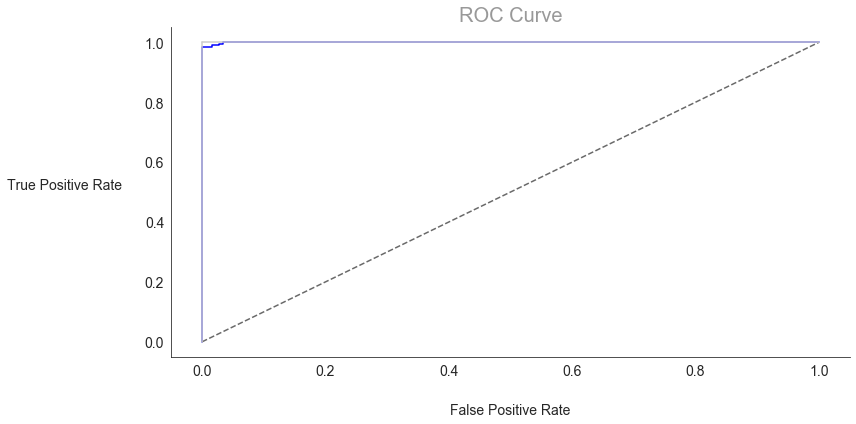

In [41]:
target_prob = pipeline.predict_proba(X_valid)[:,1] # instanciando as probalidades 
fpr, tpr, threshold = roc_curve(y_valid, target_prob) # instanciando as taxas de falso e verdadeiras

# Plotando Curva ROC
fig , ax = plt.subplots(figsize=(12, 6))
ax.plot(fpr, tpr, color='blue')
ax.plot([0, 1], ls='--', color='dimgrey'), ax.plot([0, 0], [1, 0], c=".8")
ax.plot([1, 1], c='.8')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("ROC Curve", fontsize=20, c=".6")
ax.set_xlabel("False Positive Rate", fontsize=14, labelpad=25)
ax.set_ylabel("True Positive Rate", fontsize=14, rotation=0, labelpad=80)

plt.tight_layout()

Tivemos um otimo resultado mostra que nosso modelo foi capaz de generalizar bem.